# Data Overview
_Author : Benjamin Ternot_

## I. Importing Libraries and Global Settings

In [1]:
import os
import gc
import datetime
import random

import IPython
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader as TorchDataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

from data_manager.datamanager import DataLoader, DataDisplayer, DataTransformer
from models.model import Unet

In [2]:
IMAGE_SIZE = 64

LIBERATE_MEMORY = True # Delete intermediate object to free memory space

TRAIN_MODEL = True
SAVE_MODEL = True
LOAD_MODEL = not TRAIN_MODEL
MODEL_LOAD_PATH = "models/trained_models/"

MULTI_CHANNEL = True
BATCH_SIZE = 16
EPOCHS = 50
T = 1000
DIM_MULTS = (1, 2, 4)

In [3]:
current_datetime = datetime.datetime.now()
SAVE_PATH = f"images/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + '4-channels' if MULTI_CHANNEL else '1-channel'
MODEL_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_trained-unet.pt"
PARAMS_SAVE_PATH = f"models/trained_models/{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + ('4-channels' if MULTI_CHANNEL else '1-channel') + "_params.txt"
INPUT_SAVE_PATH = SAVE_PATH + "_batch_input.jpg"
OUTPUT_SAVE_PATH = SAVE_PATH + "_sampling.jpg"
OUTPUT_ONE_HOT_SAVE_PATH = SAVE_PATH + "_sampling_one-hot.jpg"
OUTPUT_GIF_SAVE_PATH = SAVE_PATH + "_sampling.gif.png"
OUTPUT_GIF_ONE_HOT_SAVE_PATH = SAVE_PATH + "_sampling_one-hot.gif.png"

SAVE_PARAMS = {
    "IMAGE_SIZE": IMAGE_SIZE,
    "MULTI_CHANNEL": MULTI_CHANNEL,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "T": T,
    "DIM_MULTS": DIM_MULTS
}

In [4]:
# Write parameters to the file
with open(PARAMS_SAVE_PATH, "w") as file:
    for key, value in SAVE_PARAMS.items():
        file.write(f"{key} = {value}\n")
print(f"Parameters saved to '{PARAMS_SAVE_PATH}'")

Parameters saved to 'models/trained_models/2024-12-06-11-29_4-channels_params.txt'


In [5]:
# Modifier les couleurs des textes et des axes en fonction du thème de Jupyter
DARK_BG = False

if DARK_BG:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
else:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'

In [6]:
# Define the root data folder
root_data_folder = os.path.join(os.path.dirname(os.getcwd()), 'database')

# Define the sub path to the folders containing the data
data_sub_folders = {
    "train": "training",
    "test": "testing",
}

# Define the mapping from group labels to diagnostic classes
group_map = {
    "NOR": "Healthy control",
    "MINF": "Myocardial infarction",
    "DCM": "Dilated cardiomyopathy",
    "HCM": "Hypertrophic cardiomyopathy",
    "RV": "Abnormal right ventricle"
}

## II. Data Loading and Displaying

In [7]:
# Create a DataLoader instance
data_loader = DataLoader(root_data_folder)

# Load the data
for key, sub_folder in data_sub_folders.items():
    data_loader.load_data(sub_folder, name=key, store=True)


Loading data in '/home/infres/bternot-21/PRIM-AI-Diffusion-Models-for-Cardiac-Images/database/training':   0%|…

Loading data in '/home/infres/bternot-21/PRIM-AI-Diffusion-Models-for-Cardiac-Images/database/testing':   0%| …

In [8]:
# Initialize the DataDisplayer with the DataLoader instance
data_displayer = DataDisplayer(data_loader, group_map=group_map)

data_loader.data
├── train
│	├── patient093
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── patient077
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── ...
├── test
│	├── patient125
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── patient117
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	├── ...
##########################################################################################
test data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient117, height: 180.0cm, weight: 92.0kg, group: DCM, nb_frames: 30


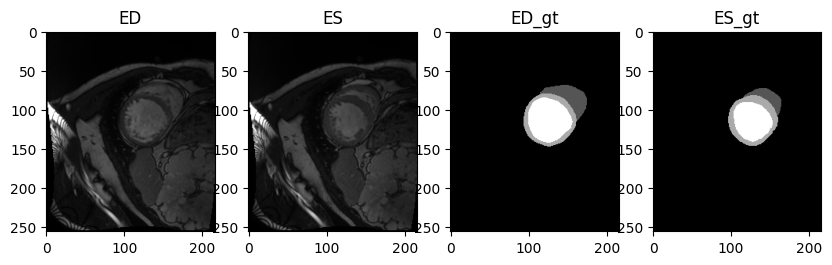

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient111, height: 172.0cm, weight: 80.0kg, group: HCM, nb_frames: 15


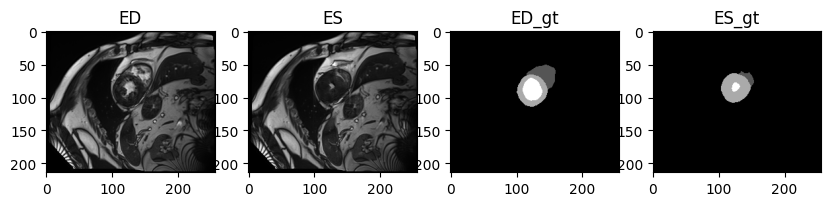

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient143, height: 161.0cm, weight: 85.0kg, group: MINF, nb_frames: 30


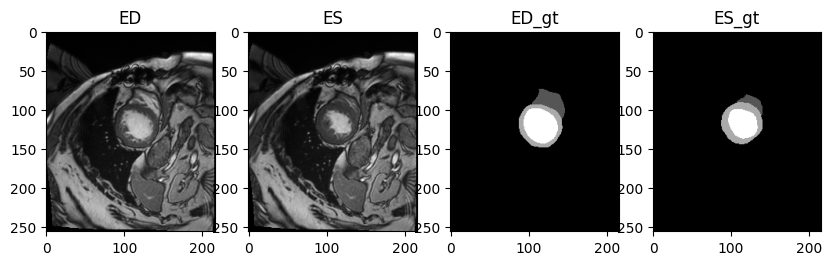

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient128, height: 170.0cm, weight: 74.0kg, group: NOR, nb_frames: 30


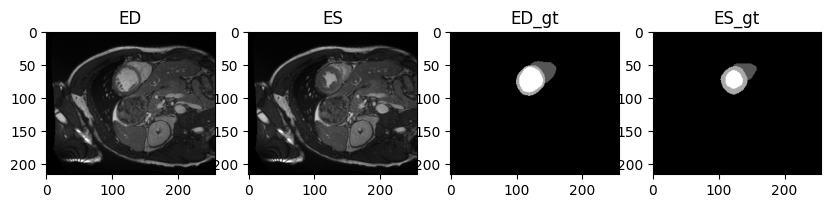

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient127, height: 165.0cm, weight: 54.0kg, group: RV, nb_frames: 18


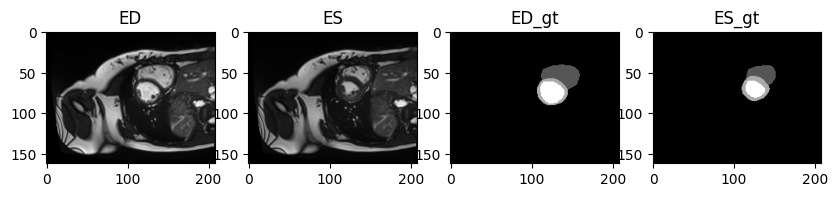

##########################################################################################
train data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient015, height: 158.0cm, weight: 57.0kg, group: DCM, nb_frames: 21


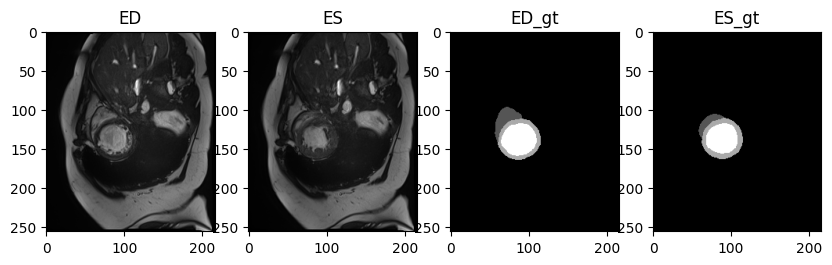

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient023, height: 166.0cm, weight: 74.0kg, group: HCM, nb_frames: 25


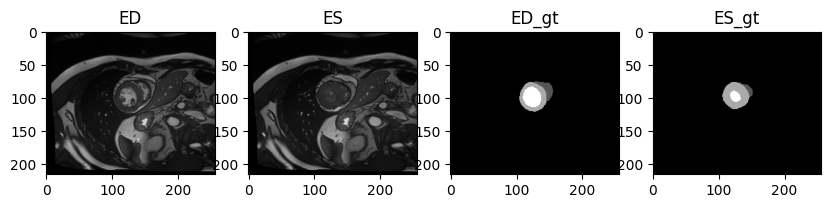

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient059, height: 173.0cm, weight: 68.0kg, group: MINF, nb_frames: 30


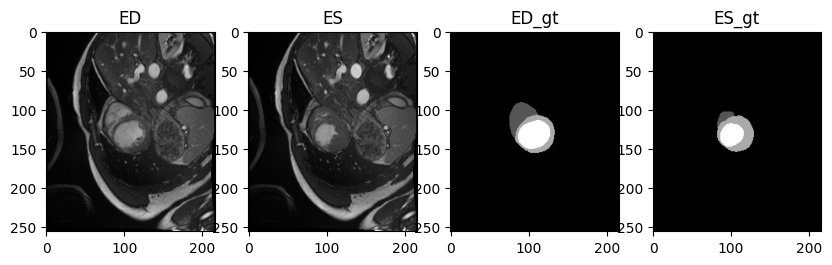

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient077, height: 180.0cm, weight: 75.0kg, group: NOR, nb_frames: 25


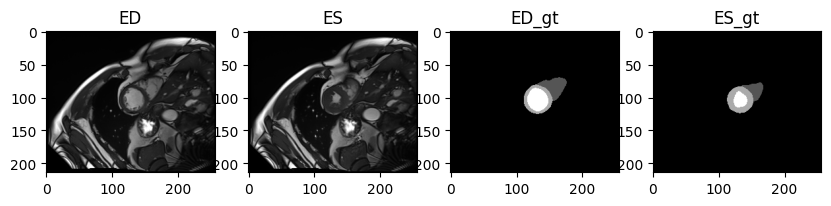

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient082, height: 183.0cm, weight: 82.0kg, group: RV, nb_frames: 17


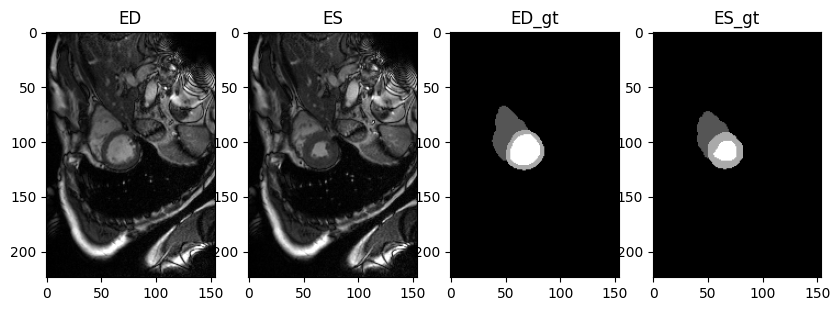

In [9]:
# Display as an arborescence the dataloader.data dictionary
print(data_displayer.display_data_arborescence('data_loader.data', max_keys={1: 2}))

# Display some examples
data_displayer.display_examples(nb_examples=1, per_combination=True, sort_by=('data_name', 'group', 'id'), format_sep=('#' * 90, '-' * 60, ''), format_categories=('{} data :\n', '{} :', '\n'))

## III. Data Overview

There are 74 different shapes in the data
X axis varies from 154 to 428
Y axis varies from 154 to 512
Z axis varies from 6 to 21
Aspect ratio (X/Y) varies from 0.6388888888888888 to 1.4545454545454546


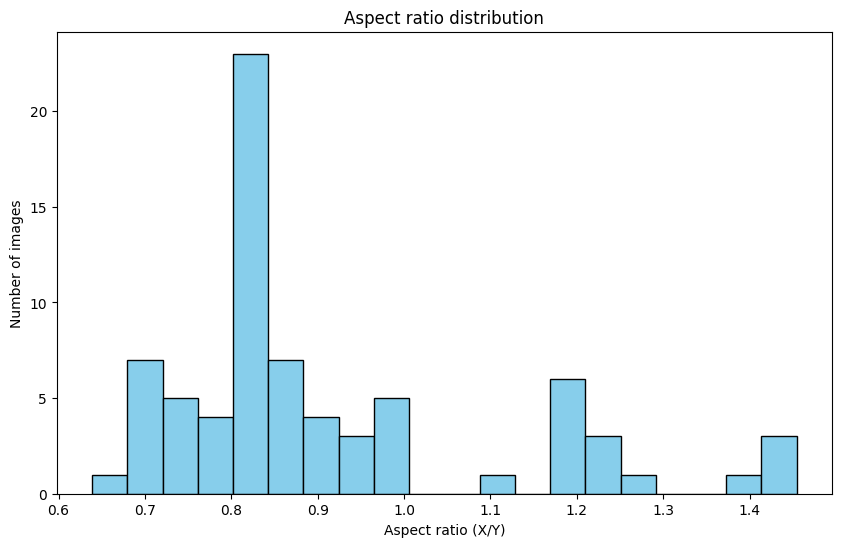

In [10]:
# Show repartition of shape of the images
shape_dict = {}
for dataset_key, dataset in data_loader.data.items():
    for patient, patient_data in dataset.items():
        for image_name, image in patient_data['image_data'].items():
            shape = image.shape
            if shape not in shape_dict:
                shape_dict[shape] = 1
            else:
                shape_dict[shape] += 1

print(
    f'There are {len(shape_dict)} different shapes in the data'
    f'\nX axis varies from {min([shape[0] for shape in shape_dict.keys()])} to {max([shape[0] for shape in shape_dict.keys()])}'
    f'\nY axis varies from {min([shape[1] for shape in shape_dict.keys()])} to {max([shape[1] for shape in shape_dict.keys()])}'
    f'\nZ axis varies from {min([shape[2] for shape in shape_dict.keys()])} to {max([shape[2] for shape in shape_dict.keys()])}'
    f'\nAspect ratio (X/Y) varies from {min([shape[0] / shape[1] for shape in shape_dict.keys()])} to {max([shape[0] / shape[1] for shape in shape_dict.keys()])}'
)
# plot the repartition of the aspect ratio
plt.figure(figsize=(10, 6))
plt.hist([shape[0] / shape[1] for shape in shape_dict.keys()], bins=20, color='skyblue', edgecolor='black')
plt.title('Aspect ratio distribution')
plt.xlabel('Aspect ratio (X/Y)')
plt.ylabel('Number of images')
plt.show()

## IV. Preprocessing

In [11]:
# Instanciate the data transformer
data_transformer = DataTransformer(data_loader)

In [12]:
# Resize the images to a common shape
target_shape = (IMAGE_SIZE, IMAGE_SIZE)
data_transformer.crop_and_resize(target_shape=target_shape, padding=0.2, output_key='image_resized_data', keep_3d_consistency=False, link_gt_to_data=False, create_channels_from_gt=MULTI_CHANNEL, image_names=['ED_gt', 'ES_gt'])

# Display tree of the data after resizing
print(data_displayer.display_data_arborescence('data_loader.data', max_keys=7))

Transforming images in 'train':   0%|          | 0/100 [00:00<?, ?it/s]

Transforming images in 'test':   0%|          | 0/50 [00:00<?, ?it/s]

data_loader.data
├── train
│	├── patient093
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient077
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient099
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient038
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── image_resized_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient032
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	

##########################################################################################
test data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient149, height: 173.0cm, weight: 70.0kg, group: DCM, nb_frames: 25


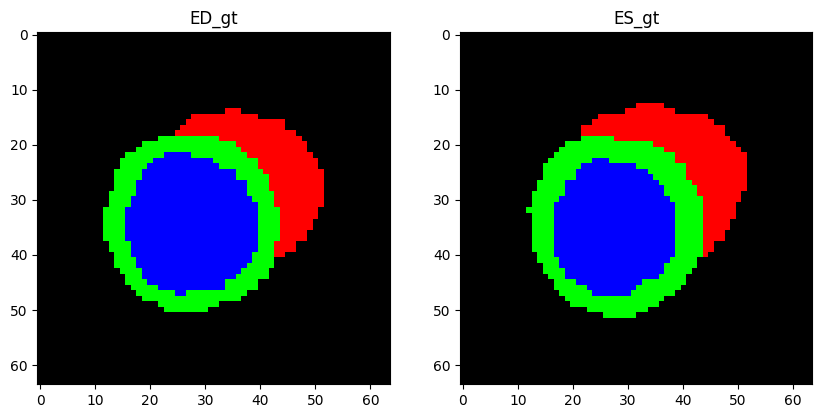

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient138, height: 174.0cm, weight: 90.0kg, group: HCM, nb_frames: 30


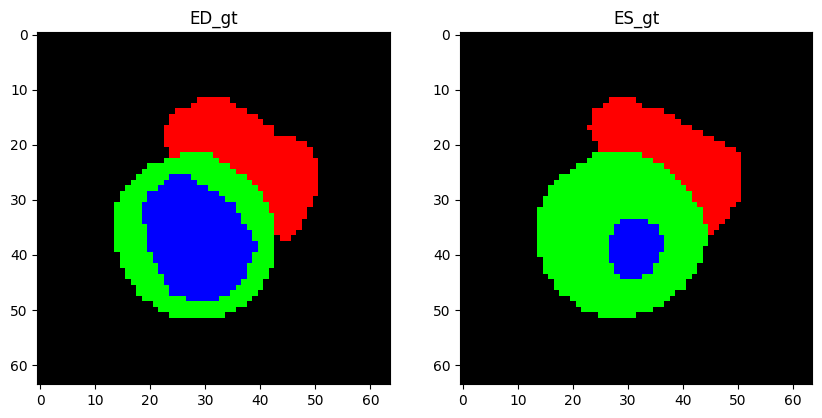

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient120, height: 161.0cm, weight: 55.0kg, group: MINF, nb_frames: 25


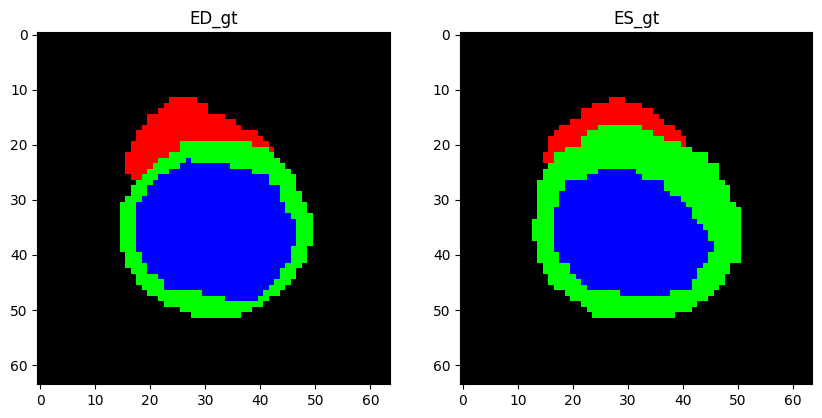

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient110, height: 167.0cm, weight: 116.0kg, group: NOR, nb_frames: 30


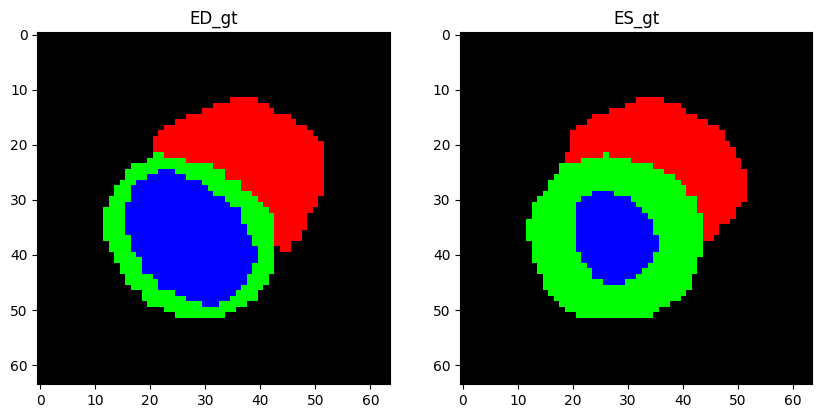

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient129, height: 183.0cm, weight: 75.0kg, group: RV, nb_frames: 16


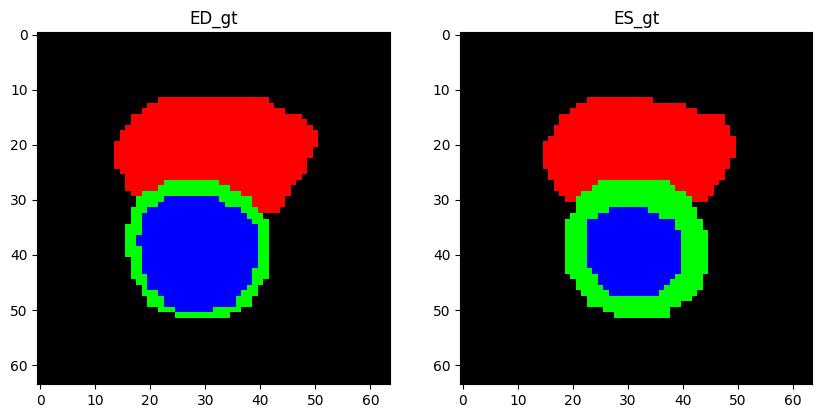

##########################################################################################
train data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient016, height: 173.0cm, weight: 54.0kg, group: DCM, nb_frames: 30


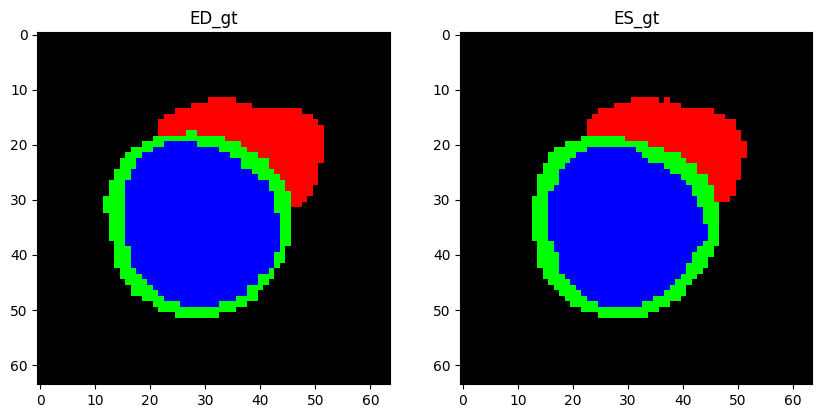

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient040, height: 172.0cm, weight: 95.0kg, group: HCM, nb_frames: 35


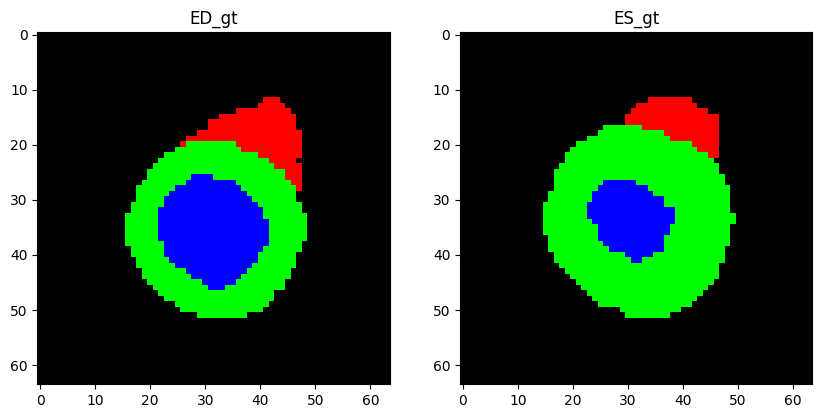

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient059, height: 173.0cm, weight: 68.0kg, group: MINF, nb_frames: 30


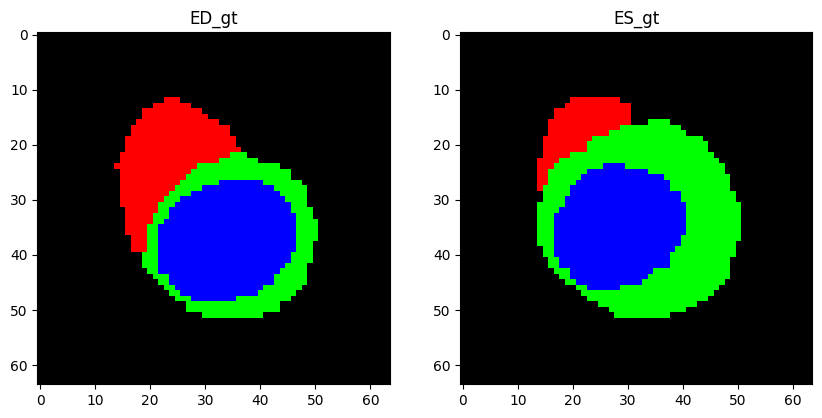

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient070, height: 158.0cm, weight: 79.0kg, group: NOR, nb_frames: 28


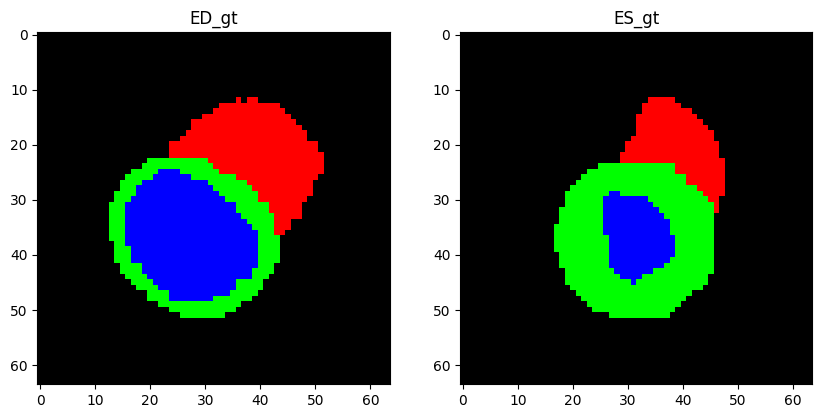

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient086, height: 165.0cm, weight: 70.0kg, group: RV, nb_frames: 19


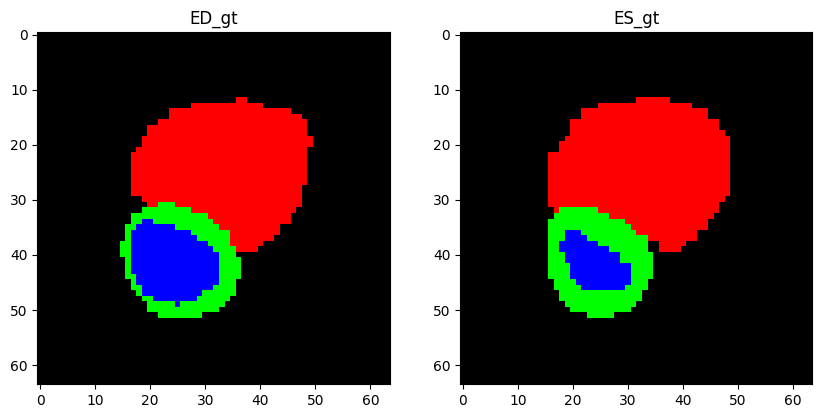

In [13]:
# Display some examples for the resized images
data_displayer.display_examples(image_type='image_resized_data', image_names=['ED_gt', 'ES_gt'], nb_examples=1, per_combination=True, sort_by=('data_name', 'group', 'id'), format_sep=('#' * 90, '-' * 60, ''), format_categories=('{} data :\n', '{} :', '\n'))

## V. Data Augmentation

In [14]:
transformed_images_gt = data_loader.extract_specific_images(image_types=['image_resized_data'], image_names=['ED_gt', 'ES_gt'])
rotated_images = []
nb_rotations = 7
max_angle = 45
for angle in tqdm(np.linspace(-max_angle, max_angle, nb_rotations), desc='Rotating images'):
    if angle == 0:
        rotated_images.append(transformed_images_gt)
    else:
        rotated_images.append(DataTransformer.rotate_images(angle=angle, images=transformed_images_gt, has_channels=transformed_images_gt[0].shape[0] > 3))
# concatenate all lists
rotated_images = [images for sublist in rotated_images for images in sublist]
print(f'Number of images after rotation: {len(rotated_images)}')

Extracting images in 'train':   0%|          | 0/100 [00:00<?, ?it/s]

Extracting images in 'test':   0%|          | 0/50 [00:00<?, ?it/s]

Rotating images:   0%|          | 0/7 [00:00<?, ?it/s]

Number of images after rotation: 2100


## Model Diffusion Process

In [15]:
DEVICE = torch.device("cuda:1") if torch.cuda.is_available() else "cpu"

## Preprocessing

In [16]:
# Dataset parameters
batch_size = BATCH_SIZE

In [17]:
training_images = data_transformer.slice_depth_images(rotated_images)
# Keep a multiple of batch_size images
training_images = training_images[:(len(training_images)//batch_size)*batch_size]
training_images = DataTransformer.one_hot_encode_batch(training_images)
print(f'Number of images after slicing: {len(training_images)}')

Slicing images:   0%|          | 0/2100 [00:00<?, ?it/s]

Number of images after slicing: 20832


In [18]:
if LIBERATE_MEMORY:
    del shape_dict
    del data_loader
    del data_transformer
    del data_displayer
    del transformed_images_gt
    del rotated_images
    gc.collect()

In [19]:
train_dataloader, channels, image_size, len_dataloader = TorchDataLoader(dataset=training_images, batch_size=batch_size, shuffle=True), training_images[0].shape[0], target_shape[0], len(training_images)//batch_size

def format_batch_shape_string(batch_shape: tuple[int]):
    return "{} image(s), {} channel(s), {} row(s), {} column(s)".format(*batch_shape)

# Get a random batch from the train_dataloader without converting it to a list
random_batch_index = random.randint(0, len(train_dataloader) - 1)
# Use iter and advance to the random index
batch_iterator = iter(train_dataloader)
for _ in range(random_batch_index):
    next(batch_iterator)  # Advance to the random batch
batch_image = next(batch_iterator)  # Get the random batch
print(f"Shape of each batch: [{format_batch_shape_string(batch_image.shape)}]")

Shape of each batch: [16 image(s), 4 channel(s), 64 row(s), 64 column(s)]


In [20]:
def normalize_im(images):
    shape = images.shape
    images = images.view(shape[0], -1)
    images -= images.min(1, keepdim=True)[0]
    images /= images.max(1, keepdim=True)[0]
    return images.view(shape)

def show_images(batch, filename=None, one_hot_encode=False):
    image = np.array(torch.permute(make_grid(batch, nrow=int(np.sqrt(len(batch)))), (1,2,0)).cpu())
    if image.shape[-1] > 3:
        if one_hot_encode:
            image = DataDisplayer.one_hot_encode(image)
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].imshow(image[..., 1:4])
        axes[0].set_title("RGB Channels")
        axes[0].axis('off')
        im_bg = axes[1].imshow(image[..., 0], cmap='viridis')
        axes[1].set_title("Background Intensity")
        axes[1].axis('off')
        cbar = fig.colorbar(im_bg, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label("Intensity")
        plt.tight_layout()
        if filename:
            fig.savefig(filename)
        plt.show()
    else:
        plt.imshow(image, cmap='gray')
        if filename:
            plt.savefig(filename)
        plt.show()

/tmp/ipykernel_1920466/4126578302.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(torch.permute(make_grid(batch, nrow=int(np.sqrt(len(batch)))), (1,2,0)).cpu())


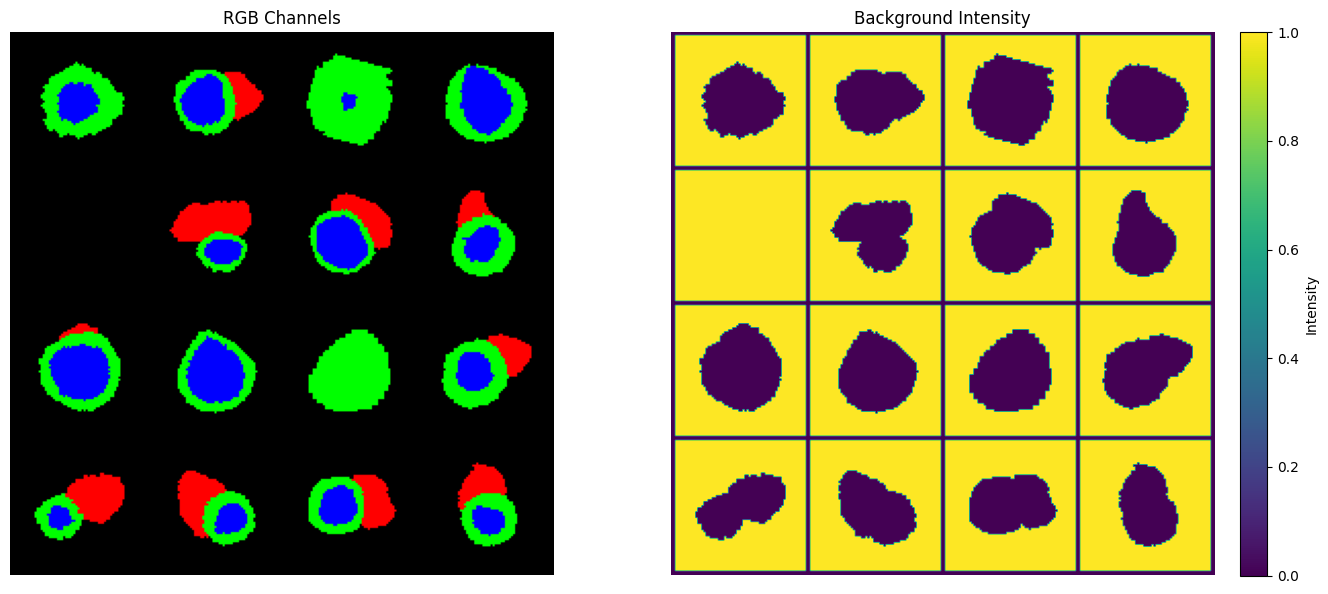

In [21]:
show_images(batch_image[:], INPUT_SAVE_PATH)

## Forward Diffusion

### Beta Scheduling

In [22]:
# Different type of beta schedule
def linear_beta_schedule(timesteps, beta_start = 0.0001, beta_end = 0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


### Constants calculation

In [23]:
# Function to get alphas and betas
def get_alph_bet(timesteps, schedule=cosine_beta_schedule):

    # define beta
    betas = schedule(timesteps)

    # define alphas
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0) # cumulative product of alpha
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # corresponding to the prev const
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    # calculations for diffusion q(x_t | x_{t-1}) and others
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

    # calculations for posterior q(x_{t-1} | x_t, x_0)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    const_dict = {
        'betas': betas,
        'sqrt_recip_alphas': sqrt_recip_alphas,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        'posterior_variance': posterior_variance
    }

    return const_dict

### Definition of $q(x_t | x_{0})$

In [24]:
# extract the values needed for time t
def extract(constants, batch_t, x_shape):
    diffusion_batch_size = batch_t.shape[0]

    # get a list of the appropriate constants of each timesteps
    out = constants.gather(-1, batch_t.cpu())

    return out.reshape(diffusion_batch_size, *((1,) * (len(x_shape) - 1))).to(batch_t.device)


In [25]:
# forward diffusion (using the nice property)
def q_sample(constants_dict, batch_x0, batch_t, noise=None):
    if noise is None:
        noise = torch.randn_like(batch_x0)

    sqrt_alphas_cumprod_t = extract(constants_dict['sqrt_alphas_cumprod'], batch_t, batch_x0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_x0.shape
    )

    return sqrt_alphas_cumprod_t * batch_x0 + sqrt_one_minus_alphas_cumprod_t * noise

timesteps: tensor([  0,  62, 124, 186, 248, 310, 372, 434, 496, 558, 620, 682, 744, 806,
        868, 930])
Original images:


/tmp/ipykernel_1920466/4126578302.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(torch.permute(make_grid(batch, nrow=int(np.sqrt(len(batch)))), (1,2,0)).cpu())


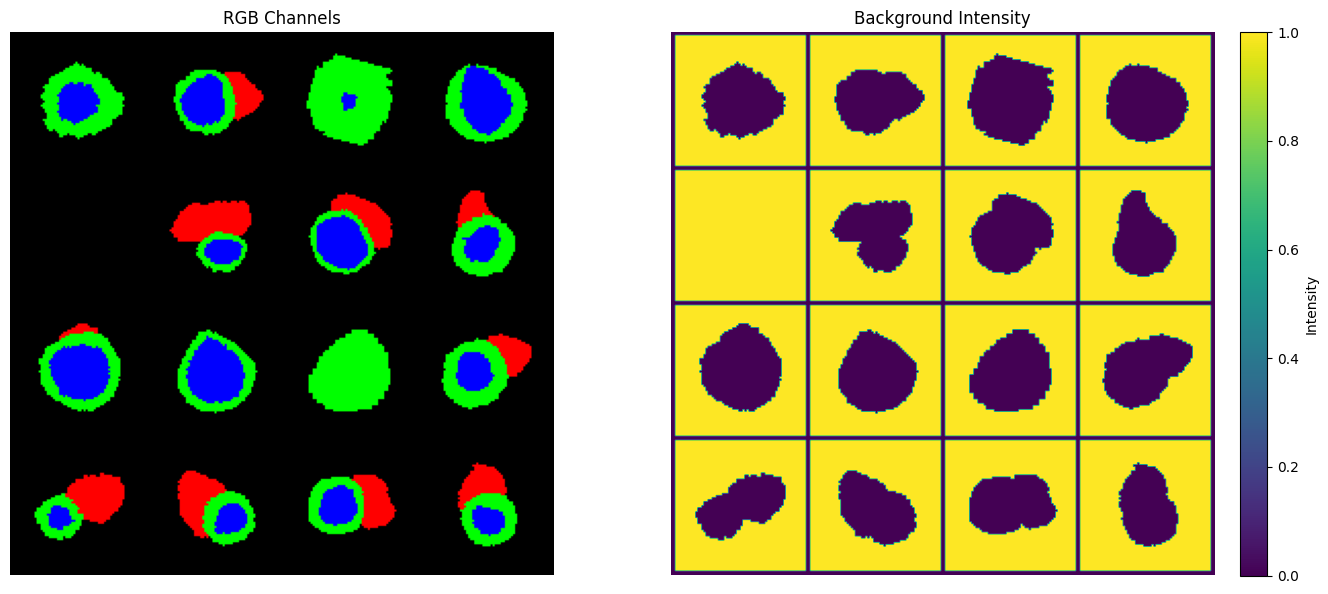

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.0913496..4.4260116].


Noised images with linear shedule:


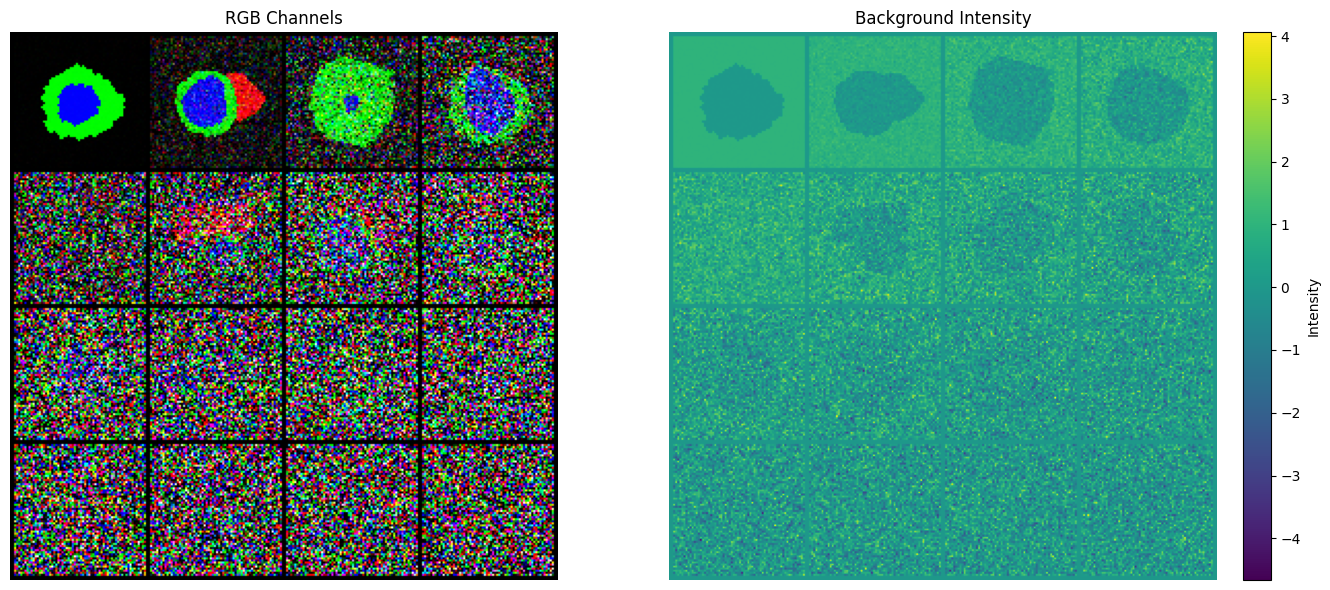

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.263548..4.45769].


Noised images with cosine shedule:


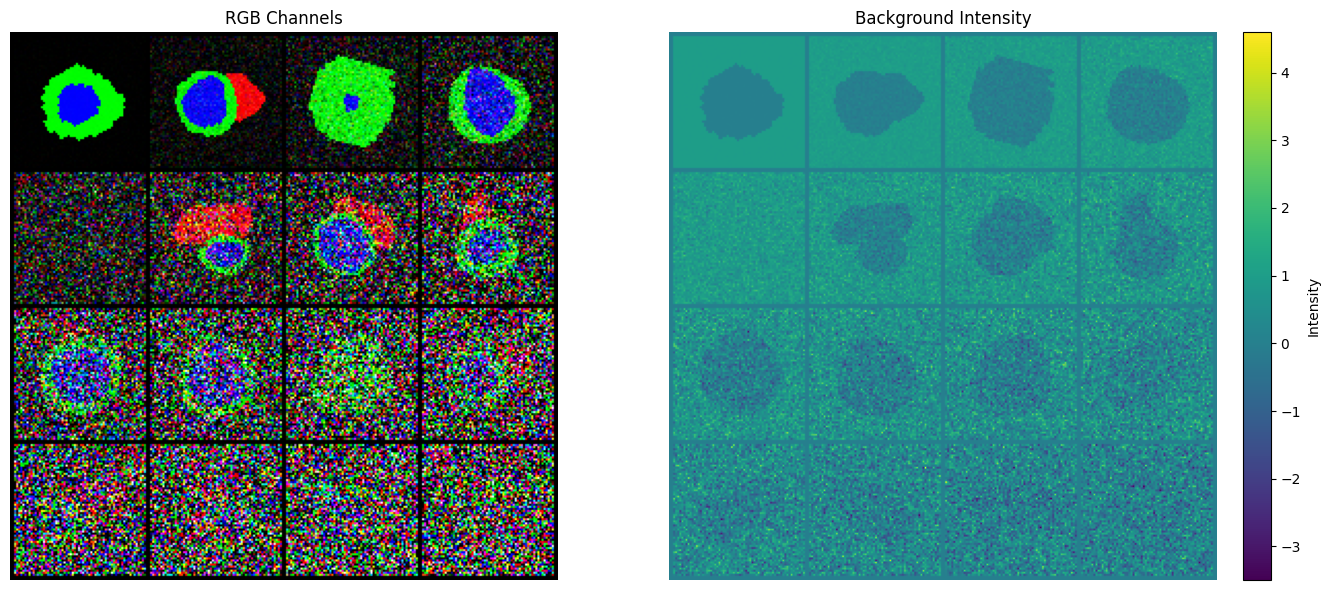

In [26]:
const_linear_dict = get_alph_bet(T, schedule=linear_beta_schedule)
const_cosine_dict = get_alph_bet(T, schedule=cosine_beta_schedule)

batch_t = torch.arange(batch_size)*(T//batch_size)  # get a range of timesteps from 0 to T
print(f"timesteps: {batch_t}")
noisy_batch_linear = q_sample(const_linear_dict, batch_image, batch_t, noise=None)
noisy_batch_cosine = q_sample(const_cosine_dict, batch_image, batch_t, noise=None)

print("Original images:")
show_images(batch_image[:])

print("Noised images with linear shedule:")
show_images(noisy_batch_linear[:])

print("Noised images with cosine shedule:")
show_images(noisy_batch_cosine[:])

## Model Diffusion Process

### Model definition

In [27]:
model = Unet(
        dim=image_size,
        init_dim=None,
        out_dim=None,
        dim_mults=DIM_MULTS,
        channels=channels,
        with_time_emb=True,
        convnext_mult=2,
    ).to(DEVICE)

### Definition of $ p_{\theta}(x_{t-1}|x_t) $

In [28]:
@torch.no_grad()
def p_sample(constants_dict, batch_xt, predicted_noise, batch_t):
    # We first get every constants needed and send them in right device
    betas_t = extract(constants_dict['betas'], batch_t, batch_xt.shape).to(batch_xt.device)
    sqrt_one_minus_alphas_cumprod_t = extract(
        constants_dict['sqrt_one_minus_alphas_cumprod'], batch_t, batch_xt.shape
    ).to(batch_xt.device)
    sqrt_recip_alphas_t = extract(
        constants_dict['sqrt_recip_alphas'], batch_t, batch_xt.shape
    ).to(batch_xt.device)

    # Equation 11 in the ddpm paper
    # Use predicted noise to predict the mean (mu theta)
    model_mean = sqrt_recip_alphas_t * (
        batch_xt - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )

    # We have to be careful to not add noise if we want to predict the final image
    predicted_image = torch.zeros(batch_xt.shape).to(batch_xt.device)
    t_zero_index = (batch_t == torch.zeros(batch_t.shape).to(batch_xt.device))

    # Algorithm 2 line 4, we add noise when timestep is not 1:
    posterior_variance_t = extract(constants_dict['posterior_variance'], batch_t, batch_xt.shape)
    noise = torch.randn_like(batch_xt)  # create noise, same shape as batch_x
    predicted_image[~t_zero_index] = model_mean[~t_zero_index] + (
        torch.sqrt(posterior_variance_t[~t_zero_index]) * noise[~t_zero_index]
    )

    # If t=1 we don't add noise to mu
    predicted_image[t_zero_index] = model_mean[t_zero_index]

    return predicted_image

## Sampling

In [29]:
# Algorithm 2 (including returning all images)
@torch.no_grad()
def sampling(model, shape, T, constants_dict):
    b = shape[0]
    # start from pure noise (for each example in the batch)
    batch_xt = torch.randn(shape, device=DEVICE)

    batch_t = torch.ones(shape[0]) * T  # create a vector with batch-size time the timestep
    batch_t = batch_t.type(torch.int64).to(DEVICE)

    imgs = []

    for t in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        batch_t -= 1
        predicted_noise = model(batch_xt, batch_t)

        batch_xt = p_sample(constants_dict, batch_xt, predicted_noise, batch_t)

        imgs.append(batch_xt.cpu())

    return imgs

## Training

In [30]:
train_dataloader, channels, image_size, len_dataloader = TorchDataLoader(dataset=training_images, batch_size=batch_size), training_images[0].shape[0], target_shape[0], len(training_images)//batch_size
constants_dict = get_alph_bet(T, schedule=linear_beta_schedule)

epochs = EPOCHS

criterion = nn.SmoothL1Loss()
optimizer = Adam(model.parameters(), lr=1e-4)

### Training loop

In [31]:
if TRAIN_MODEL:
    for epoch in range(epochs):
        loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in loop:
            optimizer.zero_grad()

            batch_size_iter = batch.shape[0]
            batch_image = batch.to(DEVICE)

            # Algorithm 1 line 3: sample t uniformally for every example in the batch
            batch_t = torch.randint(0, T, (batch_size_iter,), device=DEVICE).long()

            noise = torch.randn_like(batch_image)

            x_noisy = q_sample(constants_dict, batch_image, batch_t, noise=noise)
            predicted_noise = model(x_noisy, batch_t)

            loss = criterion(noise, predicted_noise)

            loop.set_postfix(loss=loss.item())

            loss.backward()
            optimizer.step()

    if SAVE_MODEL:
        torch.save(model.state_dict(), MODEL_SAVE_PATH)

Epoch 1/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/1302 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/1302 [00:00<?, ?it/s]

## Reload model

In [32]:
if LOAD_MODEL :
    model = Unet(
            dim=image_size,
            init_dim=None,
            out_dim=None,
            dim_mults=DIM_MULTS,
            channels=channels,
            with_time_emb=True,
            convnext_mult=2,
        ).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_LOAD_PATH, weights_only=True, map_location=torch.device(DEVICE)))
    model.eval()

## View of the diffusion process

In [33]:
def make_gif(frame_list, filename, step=5, one_hot_encode=True):    
    to_pil = ToPILImage()
    
    frames = [np.array(torch.permute(make_grid(normalize_im(tens_im), nrow=int(np.sqrt(batch_size))), (1,2,0)).cpu()) for tens_im in frame_list]
    frames_to_include = frames[0] + frames[1::step]
    if frames[-1] not in frames_to_include:
        frames_to_include.append(frames[-1])
    if frames_to_include[0].shape[-1] > 3:
        if one_hot_encode:
            frames_to_include = [DataDisplayer.one_hot_encode(frame) for frame in frames_to_include]
        frames_to_include = [frame[..., 1:4] for frame in frames_to_include]
    frames_pil = [to_pil(frame) for frame in frames_to_include]
    frame_one = frames_pil[0]
    
    frame_one.save(filename, format="GIF", append_images=frames_pil[1::], save_all=True, duration=10, loop=0)

    return IPython.display.Image(filename=filename)

check generation:


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_1920466/4126578302.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(torch.permute(make_grid(batch, nrow=int(np.sqrt(len(batch)))), (1,2,0)).cpu())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08991442..1.1008997].


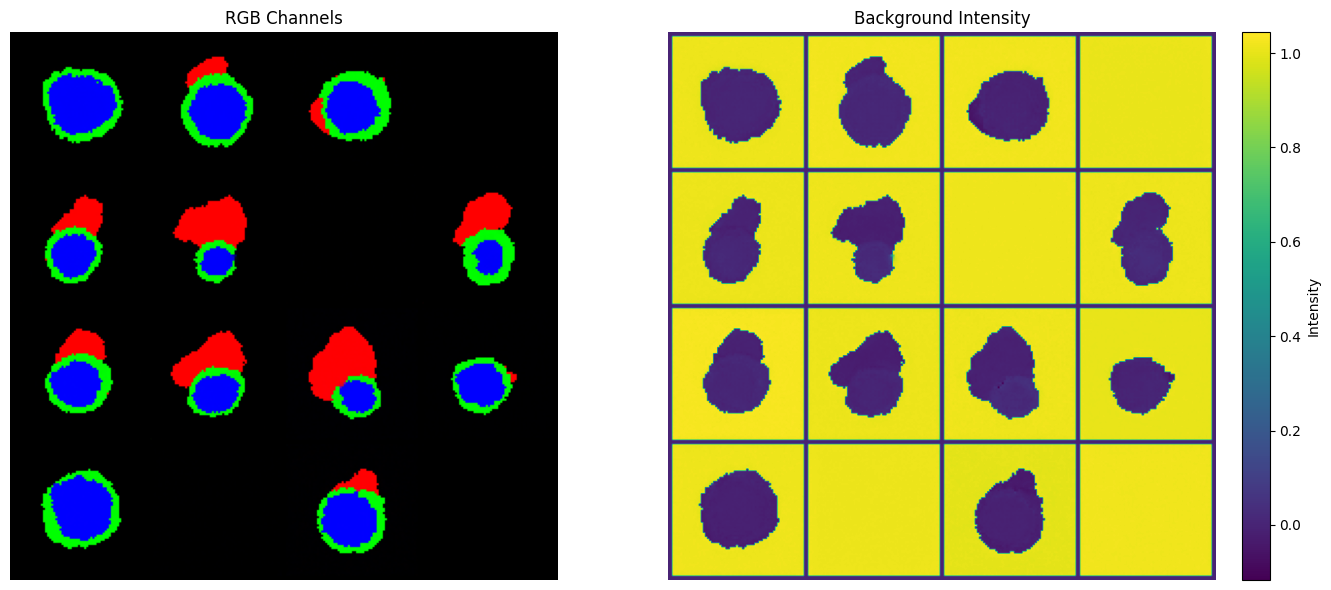

/tmp/ipykernel_1920466/4126578302.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image = np.array(torch.permute(make_grid(batch, nrow=int(np.sqrt(len(batch)))), (1,2,0)).cpu())


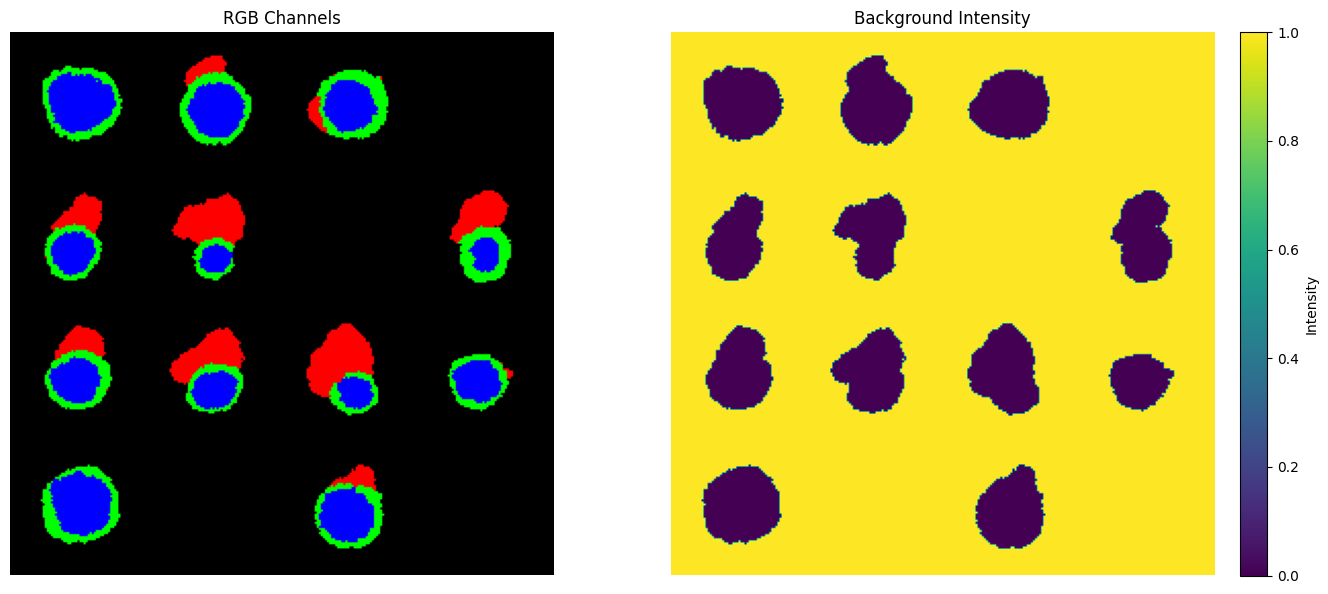

In [34]:
print("check generation:")
list_gen_imgs = sampling(model, (batch_size, channels, image_size, image_size), T, constants_dict)

show_images(list_gen_imgs[-1][:], OUTPUT_SAVE_PATH, one_hot_encode=False)
show_images(list_gen_imgs[-1][:], OUTPUT_ONE_HOT_SAVE_PATH, one_hot_encode=True)

/tmp/ipykernel_1920466/1778177928.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  frames = [np.array(torch.permute(make_grid(normalize_im(tens_im), nrow=int(np.sqrt(batch_size))), (1,2,0)).cpu()) for tens_im in frame_list]


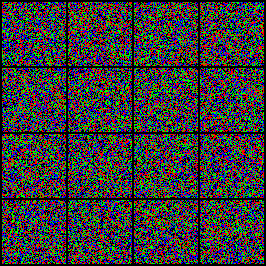

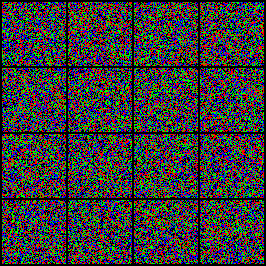

In [35]:
display(make_gif(list_gen_imgs, OUTPUT_GIF_ONE_HOT_SAVE_PATH, step=20))
display(make_gif(list_gen_imgs, OUTPUT_GIF_SAVE_PATH, step=20))

In [36]:
generated_images = []
for _ in tqdm(range(100), desc='Generating images'):
    sample = sampling(model, (batch_size, channels, image_size, image_size), T, constants_dict)
    for image in sample[-1][:]:
        generated_images.append(image)

Generating images:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]